In [4]:
import os
import pickle
import warnings
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.optimize import minimize
from scipy.stats import zscore, sem
from scipy.io import loadmat
from os.path import dirname, join as pjoin
from sklearn import linear_model, metrics
from sklearn.linear_model import Lasso, LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'

In [8]:
def RL_full_wo_decay(params, a, R, fit_bool):
    alpha_rew = np.exp(params[0])
    alpha_unr = np.exp(params[1])    
    betadq = params[2]
    beta0 = params[3]
    # decay parameter removed
    n_trials = len(a)
    
    q0 = np.array([0.5,0.5])
    QQ = np.zeros((n_trials,2))
    PP = np.zeros((n_trials,2))
    q = q0
    for t in range(n_trials):
        ev  = np.exp(betadq*(q+[0, beta0]))# expected value
        sev = sum(ev)
        p   = ev/sev
        QQ[t,:] = q
        PP[t,:] = p
        if a[t] == 1:
            if R[t] == 1:
                q[0] = q[0] + alpha_rew*(R[t]-q[0])
            elif R[t] == 0:
                q[0] = q[0] + alpha_unr*(R[t]-q[0])
            # q[1] decay term removed - no change to q[1]
        elif a[t] == 2:
            # q[0] decay term removed - no change to q[0]
            if R[t] == 1:
                q[1] = q[1] + alpha_rew*(R[t]-q[1])
            elif R[t] == 0:
                q[1] = q[1] + alpha_unr*(R[t]-q[1])
        elif a[t] == 3 or a[t] == 4:
            # Q-values remain unchanged (no decay applied)
            q[0] = q[0]
            q[1] = q[1]
            
    nloglik = -((sum(np.log(PP[a==1,0]))+sum(np.log(PP[a==2,1]))))
    if fit_bool:
        return nloglik
    else:
        return nloglik, QQ, PP

In [10]:
def prediction_accuracy_RL(a,R,PP):
    choice_trials = (a==1)|(a==2)
    a_choice=a[choice_trials]
    R_choice=R[choice_trials]
    real_L = a_choice==1 #real left choice
    P_left = PP[:,0][choice_trials]
    predicted_L = P_left > 0.5 #predicted left choice
    prediction_acc_RL = sum(real_L == predicted_L)/len(real_L)
    return prediction_acc_RL

In [11]:
def load_ForC_sessions(list_of_files):
    
    RL3_alpha_rew_all = []
    RL3_alpha_unr_all = []
    RL3_betaq_all = []
    RL3_beta0_all = []
    RL3_prediction_acc = []
    
    for ss in range(len(list_of_files)):
        data_dict=loadmat(list_of_files[ss])
        n_trials = data_dict['SessionData']['nTrials'][0][0][0][0]
        R = data_dict['R'][0]
        a = data_dict['a'][0]
  
        initial_params = np.array([np.log(0.2), np.log(0.2), 1, 0])  
        bounds = [(-np.inf,0), (-np.inf,0), (0, 15), (-1, 1)]
        lik_model = minimize(RL_full_wo_decay, initial_params, args=(a, R, 1), method='Powell', bounds=bounds)
        nloglik, QQ, PP = RL_full_wo_decay(lik_model.x, a, R, 0)
        alpha_rew = np.exp(lik_model.x[0])
        RL3_alpha_rew_all.append(alpha_rew)
        alpha_unr = np.exp(lik_model.x[1])
        RL3_alpha_unr_all.append(alpha_unr)
        betaq = lik_model.x[2] 
        RL3_betaq_all.append(betaq)
        beta0 = lik_model.x[3]
        RL3_beta0_all.append(beta0)

        prediction_acc = prediction_accuracy_RL(a,R,PP)
        RL3_prediction_acc.append(prediction_acc)
        
    return (RL3_alpha_rew_all, RL3_alpha_unr_all, RL3_betaq_all, RL3_beta0_all, RL3_prediction_acc)

## Load Short sessions

In [ ]:
# data_dir = 'short task behavioral data directory'
os.chdir(data_dir)
list_of_files0 = glob.glob('*.mat')
mouse_ids0 = [filename[:5] for filename in list_of_files0]
condition_list0 = ['Short'] * len(list_of_files0)

In [13]:
RL3_alpha_rew_all0, RL3_alpha_unr_all0, RL3_betaq_all0, RL3_beta0_all0, RL3_prediction_acc0 = load_ForC_sessions(list_of_files0)

## Load Long sessions

In [ ]:
# data_dir = 'long task behavioral data directory'
os.chdir(data_dir)
list_of_files = glob.glob('*.mat')
mouse_ids = [filename[:5] for filename in list_of_files]
condition_list = ['Long'] * len(list_of_files)

In [15]:
RL3_alpha_rew_all, RL3_alpha_unr_all, RL3_betaq_all, RL3_beta0_all, RL3_prediction_acc = load_ForC_sessions(list_of_files)

# Comparisons

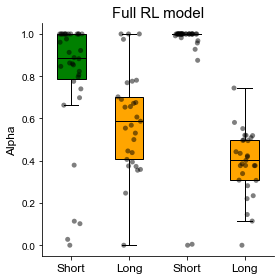

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

f, ax = plt.subplots(1, 1, sharey=False, sharex=False, figsize=[4, 4], tight_layout=True)
data = [RL3_alpha_rew_all0, RL3_alpha_rew_all, RL3_alpha_unr_all0, RL3_alpha_unr_all]
colors = ['green', 'orange', 'green','orange']

# Create boxplot with outliers hidden
bp = ax.boxplot(data, patch_artist=True, notch=False, positions=[0, 1, 2, 3], widths=0.5, showfliers=False)
# Change the color of the median bar to black for all boxes
for median in bp['medians']:
    median.set(color='black')
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_zorder(0)
    
sns.stripplot(data=data, color='black', jitter=0.2, alpha=0.5, dodge=True, zorder=1, ax=ax)
# ax.set_ylim(0, 1)
ax.set_ylabel('Alpha',fontsize=12)
ax.set_xticklabels(['Short', 'Long', 'Short', 'Long'], fontsize=12)
ax.set_title('Full RL model', fontsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()